In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
from sklearn import linear_model

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA


from fashion_model import FashionCNN 
from umap_lime import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


EXPERIMENT = 'fashion_mnist'
# EXPERIMENT = 'mnist'
# EXPERIMENT = 'compass'
# EXPERIMENT = 'german'

if EXPERIMENT == 'fashion_mnist':
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))

start_time = time.time()
umap_sampling = UMAP_sampling(all_images)
umap_duration = time.time() - start_time
print("UMAP duration: ", umap_duration)

Done loading
UMAP duration:  68.8238832950592


In [16]:
def gen_perturbation_train(X, perturbation_multiplier=10, 
                           perturbation_std = 0.3, 
                           method = 'base', 
                           embed_object = None):
    
    all_x, all_x_base, all_y = [], [], []
    
    if method == 'base':
        var = 0
        for _ in range(perturbation_multiplier):
            perturbed_xtrain = np.random.normal(0, perturbation_std, size=X.shape) 
            p_train_x = np.vstack((X, X + perturbed_xtrain))
            p_train_y = np.concatenate((np.ones(X.shape[0]), np.zeros(X.shape[0])))

            all_x.append(p_train_x)
            all_y.append(p_train_y)
            var = var + np.var(perturbed_xtrain)
        all_x = np.vstack(all_x)
        all_y = np.concatenate(all_y)
        
        return all_x, np.sqrt(var/perturbation_multiplier), all_y
    
    elif method == 'umap_ideal':
        assert embed_object != None , 'Must have embedding object (UMAP?)'
        
        var_x = 0
        var_x_base = 0
        
        for _ in range(perturbation_multiplier):
            X_low = embed_object.transform(X) # low(x)
            perturbed_low = np.random.normal(0, perturbation_std, size=X_low.shape)
            X_per_low = X_low + perturbed_low
            X_per_high = embed_object.inv_transform(X_per_low)
            
            std_high = np.sqrt(np.var(X_per_high.numpy() - X.numpy()))
            noise_high = np.random.normal(0, std_high, size=X.shape)
            
            X_per_noise = X + noise_high
            
            p_train_x = np.vstack((X, X_per_high))
            p_noise_x = np.vstack((X, X_per_noise))
            
            var_x = var_x + np.var(X_per_high.numpy() - X.numpy())
            var_x_base = var_x_base + np.var(noise_high)
            
            p_train_y = np.concatenate((np.ones(X.shape[0]), np.zeros(X.shape[0])))

            all_x.append(p_train_x)
            all_x_base.append(p_noise_x)
            all_y.append(p_train_y)
            
        all_x = np.vstack(all_x)
        all_x_base = np.vstack(all_x_base)
        all_y = np.concatenate(all_y)
        
        return all_x, np.sqrt(var_x/perturbation_multiplier), all_x_base, np.sqrt(var_x_base/perturbation_multiplier), all_y
    else:
        return None

In [17]:
all_x, std_x, all_y = gen_perturbation_train(all_images, perturbation_multiplier=2, 
                                               perturbation_std = 0.3, 
                                               method = 'base', 
                                               embed_object = None)

print(std_x)

0.29999855547173987


In [20]:
all_x, std_x, all_x_base, std_base, all_y = gen_perturbation_train(all_images[0:200], perturbation_multiplier=2, 
                                                                           perturbation_std = 0.1, 
                                                                           method = 'umap_ideal', 
                                                                           embed_object = umap_sampling)

print(std_x)
print(std_base)

0.18386318341821337
0.18333317293341475


In [21]:
all_x.shape

(800, 1, 28, 28)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def get_discriminator_performance(X,y,n_estimators = 100, test_ratio = 0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    the_rf = RandomForestClassifier(n_estimators=n_estimators).fit(X_train, y_train)
    y_pred = the_rf.predict(X_test)
    the_rf_result = (y_pred == y_test).sum()
    return the_rf_result/y_test.shape[0], X_train.shape[0]

In [25]:
def get_1d(X):
    n,c,w,h = X.shape
    return X.reshape(n,c*w*h)

In [31]:
print(get_discriminator_performance(get_1d(all_x),all_y, test_ratio = 0.95))
print(get_discriminator_performance(get_1d(all_x_base),all_y, test_ratio = 0.95))


(0.9539473684210527, 40)
(0.993421052631579, 40)


In [54]:
NUM_RUNS = 20

result = []
for test_ratio in list(np.arange(0.5,0.99,0.05)):
    accs_umap = []
    accs_base = []
    for _ in range(NUM_RUNS):
        acc_umap, _ = get_discriminator_performance(get_1d(all_x),all_y, test_ratio = test_ratio)
        acc_base, n = get_discriminator_performance(get_1d(all_x_base),all_y, test_ratio = test_ratio)
        accs_umap.append(acc_umap)
        accs_base.append(acc_base)
    mean_umap = np.mean(np.asarray(accs_umap))
    std_umap = np.std(np.asarray(accs_umap))
    mean_base = np.mean(np.asarray(accs_base))
    std_base = np.std(np.asarray(accs_base))
    result.append((n, mean_base, std_base, mean_umap, std_umap))

In [55]:
import pandas as pd

In [56]:
df = pd.DataFrame.from_records(result, columns =['NoTrain', 'Base', 'std_base', 'Manifold', 'std_manifold'])

In [57]:
df.head()

,NoTrain,Base,std_base,Manifold,std_manifold
0,400,0.998250,0.002385,0.995500,0.003500
1,359,0.998866,0.001964,0.995125,0.003946
2,319,0.998545,0.001983,0.991164,0.005376
3,279,0.998081,0.001919,0.994434,0.003374
4,239,0.998930,0.001634,0.990285,0.005057


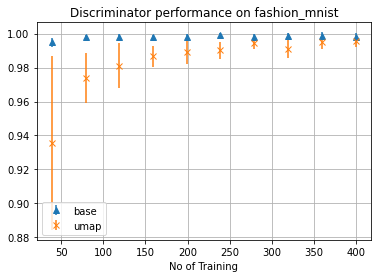

In [65]:
fig, ax = plt.subplots()
 
plt.errorbar(df['NoTrain'], df['Base'], df['std_base'], linestyle='None', marker='^', label = 'base')
plt.errorbar(df['NoTrain'], df['Manifold'], df['std_manifold'], linestyle='None', marker='x', label = 'umap')
plt.grid()
plt.title("Discriminator performance on " + EXPERIMENT)
plt.xlabel("No of Training")
plt.legend()
plt.show()

In [73]:
discriminator_file = 'results/discriminator/accuracy_on_' + EXPERIMENT + '_noise_' + str(0.1) +'_.pickle'
with open(discriminator_file, 'wb') as output:
    pickle.dump(df, output)

In [74]:
load_file = discriminator_file
with open(load_file, 'rb') as file:
    load_data = pickle.load(file)

In [75]:
load_data

,NoTrain,Base,std_base,Manifold,std_manifold
0,400,0.998250,0.002385,0.995500,0.003500
1,359,0.998866,0.001964,0.995125,0.003946
2,319,0.998545,0.001983,0.991164,0.005376
3,279,0.998081,0.001919,0.994434,0.003374
4,239,0.998930,0.001634,0.990285,0.005057
5,199,0.998003,0.001630,0.989351,0.007430
6,159,0.997816,0.001430,0.986583,0.006010
7,119,0.998164,0.001383,0.981204,0.013359
8,79,0.997920,0.001201,0.973925,0.014877
9,39,0.994809,0.002833,0.935545,0.051229


In [14]:
X_low, X_noise, InDist =  gen_perturbation_train(all_images.numpy()[0:100], 
                                                 perturbation_multiplier=3, 
                                                   perturbation_std = 0.1, 
                                                   method = 'manifold_noise_transform', 
                                                   embed_object = umap_sampling)

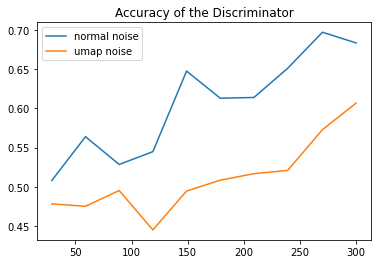

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X = X_low
y = InDist
umap_acc = []
for test_ratio in list(np.arange(0.5,0.99,0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    the_rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
    y_pred = the_rf.predict(X_test)
    the_rf_result = (y_pred == y_test).sum()
    umap_acc.append(the_rf_result/y_test.shape[0])
    
X = X_noise
y = InDist
base_acc = []
for test_ratio in list(np.arange(0.5,0.99,0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    the_rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
    y_pred = the_rf.predict(X_test)
    the_rf_result = (y_pred == y_test).sum()
    base_acc.append(the_rf_result/y_test.shape[0])
    
no_train = [v for v in list(np.arange(0.5,0.99,0.05)*y.shape[0])]
no_train = [int(y.shape[0] - v) for v in no_train]

plt.figure()
plt.plot(no_train, base_acc, label = 'normal noise')
plt.plot(no_train, umap_acc, label = 'umap noise')
plt.title("Accuracy of the Discriminator")
plt.legend()

In [90]:
from numpy import linalg as LA

no_explanations = 1
start_index = 0
sample_range = range(start_index, start_index + no_explanations)

sample_idx = 0
n_umap_samples = 2
n_nolime_samples = 25*n_umap_samples
n_lime_samples = 25*n_umap_samples


all_x, all_x_normal, all_y = [], [], []

for images, labels in train_loader:
    for i in range(images.shape[0]):
        if sample_idx not in sample_range:
            continue
            
        print("Generating instance: ", sample_idx)
        
        ex_img = images[i]
        
#         UMAP LIME
        start_time = time.time()
        ulime_seeds, ulime_perturbations, ulime_similarities, ulime_diff = umap_sampling.perturbations_generator(ex_img, 
                                                                                                                 no_samples = n_umap_samples, 
                                                                                                                 perturb_sigma = 10,
                                                                                                                 perturb_prob = 1.0,
                                                                                                                 constant_noise_mag = False,
                                                                                                                 mode = 'discrete',
                                                                                                                 kernel_width = 4,
                                                                                                                 low_manifold= True)
        
        X = ulime_perturbations - ulime_diff
        X = X.numpy()
        X_per = ulime_perturbations.numpy()
        
        normal_noise = np.random.normal(0, 1, size=X.shape)
        normal_noise = normal_noise/LA.norm(normal_noise)*LA.norm(ulime_diff.numpy())
        X_per_normal = X + normal_noise
        
        p_train_x = np.vstack((X, X_per))
        p_train_x_normal = np.vstack((X, X_per_normal))
        p_train_y = np.concatenate((np.ones(X.shape[0]), np.zeros(X.shape[0])))

        all_x.append(p_train_x)
        all_x_normal.append(p_train_x_normal)
        all_y.append(p_train_y)
    
        sample_idx = sample_idx + 1

Generating instance:  0


In [91]:
ulime_perturbations.numpy().shape

(2, 1, 28, 28)

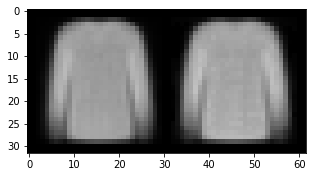

In [92]:
grid = torchvision.utils.make_grid(ulime_perturbations, nrow=10)
plt.figure(figsize=(5, 10))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [ ]:
all_x_low = [umap_sampling.transform(xdata) for xdata in all_x]

In [20]:
all_x_reshape = [xdata.reshape(4,28*28) for xdata in all_x]
all_x_reshape = np.vstack(all_x_reshape)
all_x_normal_reshape = [xdata.reshape(4,28*28) for xdata in all_x_normal]
all_x_normal_reshape = np.vstack(all_x_normal_reshape)
all_y = np.concatenate(all_y)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [86]:
test_ratio = 0.5

Xs = [all_x_reshape, all_x_normal_reshape]
ys = [all_y, all_y]

methods = zip(Xs,ys)

for X,y in methods:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    the_rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
    y_pred = the_rf.predict(X_test)
    the_rf_result = (y_pred == y_test).sum()
    print(the_rf_result/y_test.shape[0])

0.95
1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


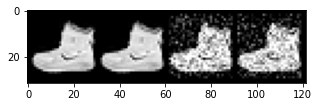

In [80]:
grid = torchvision.utils.make_grid(torch.tensor(all_x_normal[0]), nrow=4)
plt.figure(figsize=(5, 10))
plt.imshow(np.transpose(grid, (1, 2, 0)))

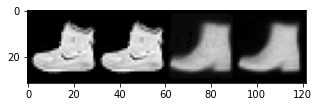

In [81]:
grid = torchvision.utils.make_grid(torch.tensor(all_x[0]), nrow=4)
plt.figure(figsize=(5, 10))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [82]:
X = all_x_reshape
y = all_y
umap_acc = []
for test_ratio in list(np.arange(0.5,0.99,0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    the_rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
    y_pred = the_rf.predict(X_test)
    the_rf_result = (y_pred == y_test).sum()
    umap_acc.append(the_rf_result/y_test.shape[0])
    
X = all_x_normal_reshape
y = all_y
base_acc = []
for test_ratio in list(np.arange(0.5,0.99,0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    the_rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
    y_pred = the_rf.predict(X_test)
    the_rf_result = (y_pred == y_test).sum()
    base_acc.append(the_rf_result/y_test.shape[0])

In [83]:
no_train = [v for v in list(np.arange(0.5,0.99,0.05)*y.shape[0])]
no_train = [int(y.shape[0] - v) for v in no_train]

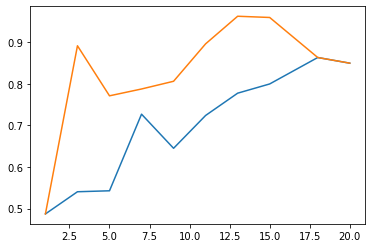

In [84]:
plt.figure()
plt.plot(no_train, base_acc)
plt.plot(no_train, umap_acc)